In [ ]:
# try to mount google colab
import os
try:
  from google.colab import drive
  drive.mount('/content/drive')
  cur_dir = "/content/drive/MyDrive/UEH_Group08_Horse Colic_Final/models"
except:
  cur_dir = "."
  pass
cur_dir = os.path.abspath(cur_dir)
os.chdir(cur_dir)

print(f'cur_dir: {cur_dir} \n --> {os.path.abspath(".")}')

Mounted at /content/drive
cur_dir: /content/drive/MyDrive/UEH_Group08_Horse Colic_Final/models 
 --> /content/drive/MyDrive/UEH_Group08_Horse Colic_Final/models


# **HORSE COLIC** (Thực nghiệm)

## Ôn tập (Review)

Trong phần trước, chúng ta đã tiến hành các bước sau:
1. Định nghĩa vấn đề
    + Mô tả vấn đề
    + Xác định đầu vào, đầu ra, loại bài toán
2. Chuẩn bị vấn đề:
    + Tải thư viện và dữ liệu
3. Phân tích dữ liệu:
    + Hiển thị thông tin dữ liệu
    + Thông tin thống kê trên các thuộc tính dữ liệu
    + Mối tương quan giữa các thuộc tính
5. Chia dữ liệu
6. Chuẩn bị dữ liệu:
    + Làm sạch dữ liệu (tạo bảng dữ liệu chỉ có thuộc tính nhập, xuất, xử lý dữ liệu thiếu và trùng lặp)
    + Biến đổi dữ liệu (label encoder, onehot encoder, chuẩn hóa)

**Kết quả**:
+ exps/data:
  + train.xlsx
  + test.xls
+ feature1:
  
  + scale_columns.npz (chứa cột biến đổi)
  + class_encoder.joblib
  
  + Feature MinMax:
    + minmax_scaler.joblib
    + feat_minmax.npz
    + df_minmax.xlsx
  
  + Feature Standard:
    + standard_scaler.joblib
    + feat_standard.npz
    + df_standard.xlsx

## Khởi tạo thí nghiệm

### Khai báo thư viện

In [ ]:
# Load libraries
import os, sys
from IPython import display
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import ticker

import pandas as pd
import seaborn as sns
import joblib
import pprint
import random

# preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

# algorithms

from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import sklearn

# metrics
from sklearn.metrics import accuracy_score , ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

import warnings

%matplotlib inline
# plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100

warnings.filterwarnings("ignore")

### Tham số thực nghiệm

In [ ]:
params = {}

params["exps_dir"]  = "../exps"
params["exp_name"]  = "horse_colic_minmax_v0"

params["exps_root"] = f'{params["exps_dir"]}/result1_standard'
params["save_dir"]  = f'{params["exps_dir"]}/result1_{params["exp_name"]}'

params["class_encoder_path"] = f'{params["exps_dir"]}/feature1/class_encoder.joblib'

params["data_path"]  = f'{params["exps_dir"]}/feature1/df_minmax.xlsx'


params["k_fold"] = 5
params["random_state"] = 42

print("params: ")
for k in params: print(f'+ {k}: {params[k]}')

# cố định random-state để phục hồi lại kết quả thí nghiệm
random.seed(params["random_state"])
os.environ['PYTHONHASHSEED'] = str(params["random_state"])
np.random.seed(params["random_state"])

params: 
+ exps_dir: ../exps
+ exp_name: horse_colic_minmax_v0
+ exps_root: ../exps/result1_standard
+ save_dir: ../exps/result1_horse_colic_minmax_v0
+ class_encoder_path: ../exps/feature1/class_encoder.joblib
+ data_path: ../exps/feature1/df_minmax.xlsx
+ k_fold: 5
+ random_state: 42


## 5. Dữ liệu kiểm nghiệm (Validation Dataset)

Chúng ta chuẩn bị dữ liệu kiểm nghiệm theo phương pháp hold-out:
+ Tập dữ liệu được chia thành 2 phần train/test với tỉ lệ 7/3 (đã làm trước)
+ Tập train sẽ được dùng để huấn luyện, điều chỉnh tham số với chiến lược:
    + Hold-out (tiếp tục chia 7/3 với train/valid)
    + k-fold (chia thành k phần đều nhau với k-1 phần cho train/1 phần cho valid)
    + Trong đó, train là dùng huấn luyện và valid dùng điều chỉnh tham số
+ Tập test dùng để kiểm nghiệm lại độ hiệu quả của thuật toán sau khi chọn mô hình tối ưu

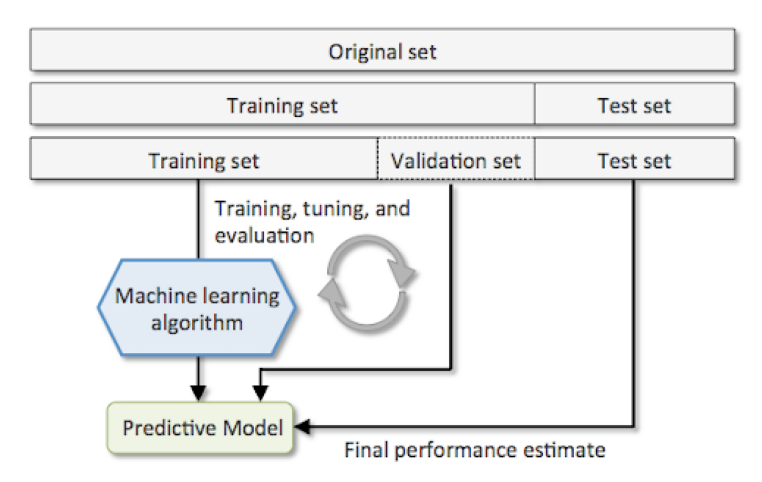

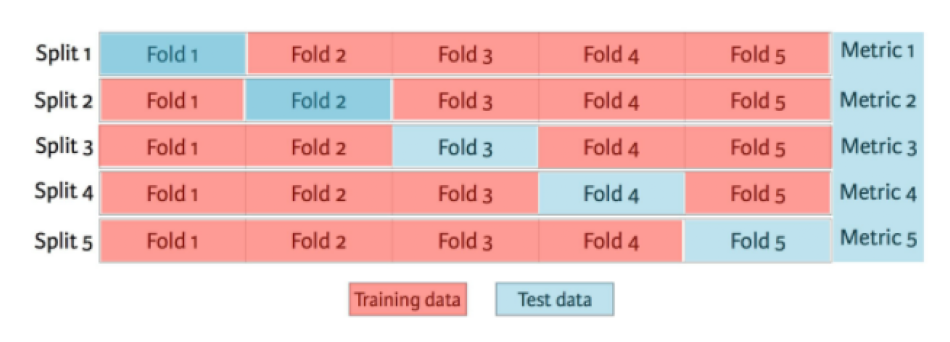

In [ ]:
plt.figure(figsize=(12,6)); plt.imshow(plt.imread("holdout.png")); plt.axis("off");
plt.figure(figsize=(12,6)); plt.imshow(plt.imread("kfold.png")); plt.axis("off");

In [ ]:
# Tải thông tin dữ liệu
df_data   = pd.read_excel(params["data_path"])

print(f'Data path [{params["data_path"]}]')
display.display(df_data)

Data path [../exps/feature1/df_minmax.xlsx]


,rectal temperature,pulse,respiratory rate,packed cell volume,total protein,temperature of extremities,peripheral pulse,mucous membranes,capillary refill time,pain,...,abdomen,abdominal distension,Surgery,Age,site of lesion,type,subtype,specific code,none,outcome
0,0.462963,0.376623,0.181818,0.269231,0.614936,0.000000,0.000000,0.200000,0.0,0.250000,...,0.000000,0.000000,1.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0
1,0.513211,0.194805,0.136364,0.430199,0.231425,1.000000,0.666667,0.600000,0.5,1.000000,...,1.000000,0.417647,0.000000,0,0.0,0.333333,0.500000,0.000000,0.555556,2
2,0.513211,0.142857,0.090909,0.615385,0.045508,0.000000,0.000000,0.400000,0.0,0.500000,...,1.000000,0.417647,1.000000,0,0.0,0.222222,0.250000,0.666667,0.444444,0
3,0.629630,0.129870,0.068182,0.288462,0.638273,0.000000,0.000000,0.000000,0.0,0.500000,...,1.000000,0.000000,0.000000,0,0.0,0.333333,0.250000,0.333333,0.111111,0
4,0.444444,0.272727,0.253331,0.634615,0.894982,0.666667,0.666667,0.000000,0.0,1.000000,...,0.000000,0.000000,0.000000,0,0.0,0.333333,0.250000,0.333333,0.111111,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,0.574074,0.454545,0.253331,0.430199,0.231425,0.666667,0.666667,0.800000,0.5,0.750000,...,1.000000,1.000000,1.000000,0,0.0,0.258347,0.250000,0.480569,0.258347,2
380,0.464094,0.042009,0.096244,0.266974,0.818836,0.666667,0.000000,0.000000,0.0,0.720659,...,0.882636,0.343229,0.000000,0,0.0,0.372455,0.250000,0.333333,0.124152,2
381,0.513211,0.200932,0.144941,0.430199,0.231425,0.937098,0.540862,0.486776,0.5,1.000000,...,1.000000,0.527541,0.000000,0,0.0,0.333333,0.500000,0.000000,0.555556,2
382,0.581827,0.216357,0.168982,0.430199,0.177951,0.907043,0.666667,0.600000,0.5,0.860564,...,1.000000,0.487091,0.278871,0,0.0,0.364319,0.500000,0.000000,0.555556,2


In [ ]:
# Chia dữ liệu thành trường input/output
X_train, y_train = df_data.values[:, :-1], df_data.values[:, -1].astype(np.int)

In [ ]:
print(f'+ x_shape: {X_train.shape}, y_shape: {y_train.shape}')
print(f'+ Input:\n{X_train[:20, :]}')
print(f'+ Output:\n{y_train[:20]}')

+ x_shape: (384, 23), y_shape: (384,)
+ Input:
[[0.46296296 0.37662338 0.18181818 0.26923077 0.61493582 0.
  0.         0.2        0.         0.25       0.33333333 0.5
  0.         1.         0.         0.         1.         0.
  0.         0.         0.         0.         0.        ]
 [0.51321138 0.19480519 0.13636364 0.43019943 0.23142538 1.
  0.66666667 0.6        0.5        1.         1.         0.5
  0.         1.         1.         0.41764706 0.         0.
  0.         0.33333333 0.5        0.         0.55555556]
 [0.51321138 0.14285714 0.09090909 0.61538462 0.04550758 0.
  0.         0.4        0.         0.5        0.66666667 0.5
  1.         1.         1.         0.41764706 1.         0.
  0.         0.22222222 0.25       0.66666667 0.44444444]
 [0.62962963 0.12987013 0.06818182 0.28846154 0.63827305 0.
  0.         0.         0.         0.5        0.         0.
  0.         0.66666667 1.         0.         0.         0.
  0.         0.33333333 0.25       0.33333333 0.11111111

## 6. Lượng giá thuật toán (Evaluate Algorithms)

### 6.1. Baselines

In [ ]:
kfold = KFold(n_splits=params["k_fold"], shuffle=True, random_state=params["random_state"])
print(f"+ X_train: {len(X_train)}")
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    print(f'Fold {fold}: ')
    print(f'+ train_idx: {train_idx}')
    print(f'+ valid_idx: {valid_idx}')
    print(f'+ train / valid: {valid_idx}')
    pass

+ X_train: 384
Fold 0: 
+ train_idx: [  1   2   4   6   7   8  10  11  12  13  14  16  17  19  20  21  23  24
  26  27  28  29  32  34  35  36  37  38  40  41  43  44  47  48  49  50
  51  52  53  54  58  59  60  61  62  64  65  66  67  68  69  70  71  74
  75  79  80  81  83  85  86  87  88  89  91  92  94  95  96  97  98  99
 100 101 102 103 105 106 107 109 111 112 115 117 119 120 121 122 123 125
 127 128 129 130 131 132 133 134 135 136 138 140 142 143 144 146 147 148
 149 150 151 153 154 155 156 157 159 160 161 162 163 164 165 166 168 169
 170 171 172 173 174 177 178 179 180 182 183 184 185 186 187 188 189 190
 191 192 193 194 196 197 199 200 201 202 203 204 205 206 207 208 209 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 226 227 228 229 230
 232 234 235 236 237 239 240 241 242 243 244 246 248 251 252 253 254 255
 256 257 258 259 260 263 264 265 266 267 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 284 285 286 287 288 289 290 291 292 293 294 295
 297 298 299 3

In [ ]:
X_train[[0, 2, 10]]

array([[0.46296296, 0.37662338, 0.18181818, 0.26923077, 0.61493582,
        0.        , 0.        , 0.2       , 0.        , 0.25      ,
        0.33333333, 0.5       , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.51321138, 0.14285714, 0.09090909, 0.61538462, 0.04550758,
        0.        , 0.        , 0.4       , 0.        , 0.5       ,
        0.66666667, 0.5       , 1.        , 1.        , 1.        ,
        0.41764706, 1.        , 0.        , 0.        , 0.22222222,
        0.25      , 0.66666667, 0.44444444],
       [0.35185185, 0.38961039, 0.36363636, 0.80769231, 0.54492415,
        0.66666667, 0.        , 1.        , 0.5       , 1.        ,
        1.        , 0.5       , 0.5       , 0.        , 1.        ,
        0.66666667, 0.        , 0.        , 0.        , 0.33333333,
        0.5       , 0.        , 0.55555556]])

In [ ]:
y_train[[0,2,10]]

array([0, 0, 2])

In [ ]:
# Mô hình mặc định (models, results, hyper-parameters)
baseline_models  = {}
baseline_results = {}


# khởi tạo các tham số mặc định
baseline_models['KNN'] = KNeighborsClassifier() #1
baseline_models['NB'] = GaussianNB() #2
baseline_models['SVM'] = SVC(random_state=params["random_state"]) #3
baseline_models['CART'] = DecisionTreeClassifier(random_state=params["random_state"]) #4
baseline_models['RF'] = RandomForestClassifier(random_state=params["random_state"]) #5
baseline_models['AdaBoost'] = AdaBoostClassifier(random_state=params["random_state"]) #6
baseline_models['GradientBoosting'] = GradientBoostingClassifier(random_state=params["random_state"]) #7
baseline_models['LDA'] = LinearDiscriminantAnalysis() #8
baseline_models['MLP'] = MLPClassifier(random_state=params["random_state"]) #9
baseline_models['LR'] = LogisticRegression(random_state=params["random_state"]) #10

# Huấn luyện từng mô hình cơ sở
for model_name in baseline_models:

    baseline_results[model_name] = {'accuracy': [], 'f1': [], 'precision': [], 'recall': []}

    print(f'Model [{model_name}]:')

    # Chiến lược chia dữ liệu trên tập X_train
    kfold = KFold(n_splits=params["k_fold"], shuffle=True, random_state=params["random_state"])

    # Tách X_train, y_train thành 2 tập train, valid trên từng fold
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
        X1_train, y1_train = X_train[train_idx], y_train[train_idx]
        X1_valid, y1_valid = X_train[valid_idx], y_train[valid_idx]
        # Lấy mô hình khởi tạo
        model_clf = sklearn.base.clone(baseline_models[model_name])
        # Huấn luyện mô hình
        model_clf.fit(X1_train, y1_train)
        # Lượng giá mô hình
        y1_pred_valid = model_clf.predict(X1_valid)
        # Tính toán metrics: accuracy, f1-score, precision, recall
        valid_acc = accuracy_score(y1_valid, y1_pred_valid)
        valid_f1 = f1_score(y1_valid, y1_pred_valid, average='weighted')
        valid_precision = precision_score(y1_valid, y1_pred_valid, average='weighted')
        valid_recall = recall_score(y1_valid, y1_pred_valid, average='weighted')
        # Lưu metrics trên từng fold
        baseline_results[model_name]['accuracy'].append(valid_acc)
        baseline_results[model_name]['f1'].append(valid_f1)
        baseline_results[model_name]['precision'].append(valid_precision)
        baseline_results[model_name]['recall'].append(valid_recall)
        pass # fold
       #   hiển thị tham số mô hình
    print(f'+ params = {baseline_models[model_name].get_params()}')

    # Hiển thị các metrics trung bình và độ lệch chuẩn qua các fold
    for metric in ['accuracy', 'f1', 'precision', 'recall']:
        mean_metric = np.mean(baseline_results[model_name][metric])
        std_metric = np.std(baseline_results[model_name][metric])
        print(f'+ mean_{metric} = {mean_metric:.6f} +/- {std_metric:.6f}')

    # Huấn luyện lại với trên toàn bộ dữ liệu train (re-fit all train_data)
    baseline_models[model_name].fit(X_train, y_train)
    pass # model

Model [KNN]:
+ params = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
+ mean_accuracy = 0.791866 +/- 0.042057
+ mean_f1 = 0.783509 +/- 0.042318
+ mean_precision = 0.809169 +/- 0.032791
+ mean_recall = 0.791866 +/- 0.042057
Model [NB]:
+ params = {'priors': None, 'var_smoothing': 1e-09}
+ mean_accuracy = 0.612133 +/- 0.036608
+ mean_f1 = 0.580150 +/- 0.038652
+ mean_precision = 0.694553 +/- 0.069877
+ mean_recall = 0.612133 +/- 0.036608
Model [SVM]:
+ params = {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
+ mean_accuracy = 0.830930 +/- 0.040615
+ mean_f1 = 0.829375 +/- 0.040994
+ mean_precision = 0.841369 +/- 0.042205
+ mean_recall = 0.830930 +/- 0.040615
Mo

In [38]:
import pandas as pd
from statistics import mean

# Đoạn code huấn luyện mô hình và thu thập kết quả đánh giá ở trên

# Tạo DataFrame từ baseline_results
models_summary_df = pd.DataFrame({
    'Classifier': baseline_results.keys(),
    'Accuracy': [mean(baseline_results[classifier]['accuracy']) for classifier in baseline_results.keys()],
    'F1': [mean(baseline_results[classifier]['f1']) for classifier in baseline_results.keys()],
    'Precision': [mean(baseline_results[classifier]['precision']) for classifier in baseline_results.keys()],
    'Recall': [mean(baseline_results[classifier]['recall']) for classifier in baseline_results.keys()],
    'Average score': [mean([mean(baseline_results[classifier][metric]) for metric in ['accuracy', 'f1', 'precision', 'recall']]) for classifier in baseline_results.keys()],
    'Average std': [mean([np.std(baseline_results[classifier][metric]) for metric in ['accuracy', 'f1', 'precision', 'recall']]) for classifier in baseline_results.keys()],
   # 'Best params': [baseline_models[classifier].get_params() for classifier in baseline_results.keys()]
})

# Sắp xếp DataFrame theo điểm số trung bình giảm dần
models_summary_df = models_summary_df.sort_values('Average score', ascending=False)

models_summary_df


,Classifier,Accuracy,F1,Precision,Recall,Average score,Average std
6,GradientBoosting,0.867191,0.867241,0.871693,0.867191,0.868329,0.030650
4,RF,0.856938,0.857007,0.863324,0.856938,0.858552,0.031945
2,SVM,0.830930,0.829375,0.841369,0.830930,0.833151,0.041107
8,MLP,0.804921,0.802154,0.810035,0.804921,0.805508,0.057841
5,AdaBoost,0.802016,0.803014,0.812928,0.802016,0.804994,0.027500
0,KNN,0.791866,0.783509,0.809169,0.791866,0.794103,0.039806
3,CART,0.786535,0.786931,0.791414,0.786535,0.787853,0.040238
7,LDA,0.778947,0.777254,0.787365,0.778947,0.780629,0.066744
9,LR,0.778811,0.777759,0.783188,0.778811,0.779642,0.036423
1,NB,0.612133,0.580150,0.694553,0.612133,0.624742,0.045436


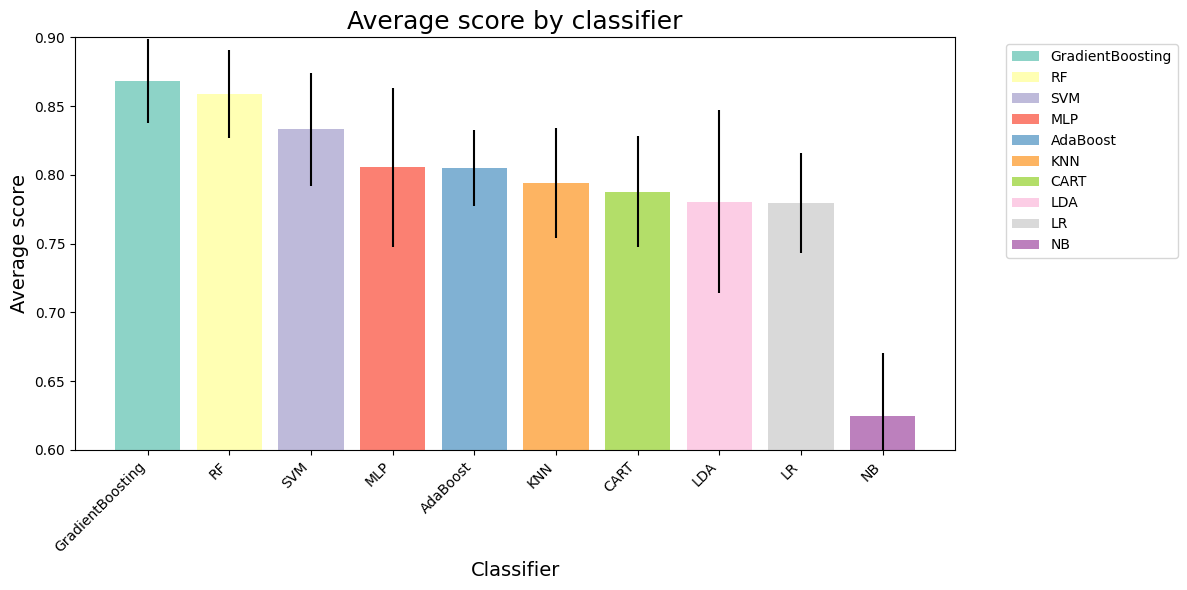

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(12, 6))

colors = [mpl.cm.Set3(i) for i in range(len(models_summary_df))]
bars = ax.bar(models_summary_df['Classifier'],
              models_summary_df['Average score'],
              yerr=models_summary_df['Average std'],
              color=colors)

ax.set_xticklabels(models_summary_df['Classifier'], rotation=45, ha='right')
ax.set_ylim(0.6, 0.9)
ax.set_title('Average score by classifier', fontsize=18)
ax.set_xlabel('Classifier', fontsize=14)
ax.set_ylabel('Average score', fontsize=14)
ax.legend(bars, models_summary_df['Classifier'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


### 6.2. Tinh chỉnh mô hình (Tuning Models)

In [ ]:
tunning_results = {
    "best_clf"   : {},
    "best_score" : {},
}

tunning_models  = {}
tunning_params  = {}
# khởi tạo các tham số mặc định
tunning_models['RandomForest'] = RandomForestClassifier(random_state=params["random_state"])
tunning_params['RandomForest'] = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

tunning_models['GradientBoosting'] = GradientBoostingClassifier(random_state=params["random_state"])
tunning_params['GradientBoosting'] = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

for model_name in tunning_models:
    model_clf = tunning_models[model_name]

    print(f'Model [{model_name}]:')

    kfold = KFold(n_splits=params["k_fold"], shuffle=True, random_state=params["random_state"])

    grid_clf = GridSearchCV(estimator=model_clf,
                            param_grid=tunning_params[model_name],
                            cv=kfold, scoring="accuracy")
    grid_result = grid_clf.fit(X_train, y_train)

    # lưu mô hình tốt nhất
    tunning_results["best_clf"][model_name] = grid_clf.best_estimator_

    # lấy kết quả tìm kiếm
    tunning_results["best_score"][model_name] = grid_result.best_score_

    # thông tin
    print(f'+ Best score: {grid_result.best_score_}')
    print(f'+ Best turning params: {grid_result.best_params_}')
    print(f'+ Best full params: {grid_clf.best_estimator_.get_params()}')
    print()


Model [RandomForest]:
+ Best score: 0.8621326042378673
+ Best turning params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
+ Best full params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Model [GradientBoosting]:
+ Best score: 0.8671907040328092
+ Best turning params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
+ Best full params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_esti

## 7. Kiểm nghiệm kết quả trên Test (Finalize Model)

### Load và tiền xử lý tập test

In [ ]:
dtype = {
    'lesion type 1': str,
    'lesion type 2': str,
    'lesion type 3': str
}

# Load dữ liệu từ file Excel và sử dụng dtype để định dạng các cột
df_test = pd.read_excel(f'{params["exps_dir"]}/data/test.xlsx', dtype=dtype)

print("Test: ", len(df_test))
display.display(df_test.head())


Test:  90


,Surgery,Age,Hospital ID,rectal temperature,pulse,respiratory rate,temperature of extremities,peripheral pulse,mucous membranes,capillary refill time,...,packed cell volume,total protein,abdominocentesis appearance,abdomcentesis total protein,outcome,surgical lesion?,lesion type 1,lesion type 2,lesion type 3,cp_data
0,2,1,529685,37.2,36.0,9.0,1.0,1.0,1.0,1.0,...,35.0,5.7,NaN,NaN,1,2,31110,00000,00000,2
1,2,1,529865,38.6,68.0,20.0,2.0,1.0,3.0,1.0,...,38.0,6.5,1.0,NaN,1,2,05124,00000,00000,1
2,1,1,533836,NaN,100.0,NaN,3.0,3.0,4.0,2.0,...,68.0,64.0,3.0,2.0,1,1,02209,00000,00000,2
3,2,9,5299629,38.3,90.0,NaN,1.0,NaN,1.0,1.0,...,40.0,6.2,1.0,2.2,1,2,00000,00000,00000,1
4,1,1,530526,38.3,72.0,30.0,4.0,3.0,3.0,2.0,...,43.0,7.0,2.0,3.9,1,1,03113,00000,00000,1


In [ ]:

#replace the value 9 to 2 in the age column
df_test["Age"]=df_test["Age"].replace(to_replace=9,value=2)



In [ ]:


class ColumnDropperTransformer:
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self

columnDropper = ColumnDropperTransformer(['Hospital ID','nasogastric reflux PH', 'abdomcentesis total protein', 'abdominocentesis appearance',
                                          'surgical lesion?', 'cp_data'
                                          ])

df_test = columnDropper.transform(df_test)
#df_test.info()



In [ ]:
#drop lesion type 2, 3
col=["lesion type 2","lesion type 3"]

df_test.drop(col,axis=1,inplace=True)

In [ ]:
df_test[['site of lesion','type','subtype','specific code','none']]=df_test['lesion type 1'].astype(str).apply(lambda x: pd.Series(list(x))).astype(float)

In [ ]:

#splitting the values of the column (type of lesion) into 4 columns
df_test[['site of lesion','type','subtype','specific code','none']]=df_test['lesion type 1'].astype(str).apply(lambda x: pd.Series(list(x))).astype(float)
df_test.drop('lesion type 1', axis=1, inplace=True)

In [ ]:
from sklearn.compose import ColumnTransformer

class CustomColumnTransformer:
    def __init__(self, transformations, remainder="passthrough", names_mapper = lambda x: x):
        self.transformations=transformations
        self.remainder = remainder
        self.names_mapper = names_mapper #it will be useful in later CustomColumnTransformer usage

    def transform(self,X,y=None):
        ct =  ColumnTransformer(self.transformations, remainder=self.remainder).set_output(transform="pandas")
        result = ct.fit_transform(X)
        #Result columns names are determined by "{transformation_name}__{original_column_name}", so we need to delete this first part.
        result.columns = [self.names_mapper(name[name.index('__')+2:]) for name in ct.get_feature_names_out()]
        return result

    def fit(self, X, y=None):
        return self

In [ ]:
from sklearn.impute import SimpleImputer, KNNImputer

#these columns will be imputed with a mean

continuousColumns = ['rectal temperature', 'pulse', 'respiratory rate', 'packed cell volume', 'total protein', ]
#these columns will be imputed with a median
discreteColumns = ['temperature of extremities','peripheral pulse','mucous membranes', 'capillary refill time', 'pain', 'peristalsis', 'nasogastric tube', 'nasogastric reflux', 'rectal examination - feces', 'abdomen', ]
#this column will be imputed with a KNN because its marked as an important parameter
knnColumns = ['abdominal distension']

fillNaTransformer = CustomColumnTransformer([
    ('fillWithMean', SimpleImputer(strategy='mean'), continuousColumns),
    ('fillWithMedian', SimpleImputer(strategy="most_frequent"), discreteColumns),
    ('fillWithKnn', KNNImputer(n_neighbors=3), knnColumns)
])

df_test = fillNaTransformer.transform(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   rectal temperature          90 non-null     float64
 1   pulse                       90 non-null     float64
 2   respiratory rate            90 non-null     float64
 3   packed cell volume          90 non-null     float64
 4   total protein               90 non-null     float64
 5   temperature of extremities  90 non-null     float64
 6   peripheral pulse            90 non-null     float64
 7   mucous membranes            90 non-null     float64
 8   capillary refill time       90 non-null     float64
 9   pain                        90 non-null     float64
 10  peristalsis                 90 non-null     float64
 11  nasogastric tube            90 non-null     float64
 12  nasogastric reflux          90 non-null     float64
 13  rectal examination - feces  90 non-nu

In [ ]:
# Class Encoder
class_encoder = joblib.load(f'{params["exps_dir"]}/feature1/class_encoder.joblib')
df_test["outcome"] = class_encoder.transform(df_test["outcome"])
display.display(df_test.head())

,rectal temperature,pulse,respiratory rate,packed cell volume,total protein,temperature of extremities,peripheral pulse,mucous membranes,capillary refill time,pain,...,abdomen,abdominal distension,Surgery,Age,outcome,site of lesion,type,subtype,specific code,none
0,37.200000,36.0,9.000000,35.0,5.7,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,2,1,0,3.0,1.0,1.0,1.0,0.0
1,38.600000,68.0,20.000000,38.0,6.5,2.0,1.0,3.0,1.0,3.0,...,5.0,2.0,2,1,0,0.0,5.0,1.0,2.0,4.0
2,38.162667,100.0,30.895522,68.0,64.0,3.0,3.0,4.0,2.0,2.0,...,5.0,4.0,1,1,0,0.0,2.0,2.0,0.0,9.0
3,38.300000,90.0,30.895522,40.0,6.2,1.0,3.0,1.0,1.0,5.0,...,5.0,1.0,2,2,0,0.0,0.0,0.0,0.0,0.0
4,38.300000,72.0,30.000000,43.0,7.0,4.0,3.0,3.0,2.0,3.0,...,5.0,3.0,1,1,0,0.0,3.0,1.0,1.0,3.0


In [ ]:
# MinMax Encoder
minmax_scaler = joblib.load(f'{params["exps_dir"]}/feature1/minmax_scaler.joblib')
display.display(minmax_scaler.__dict__)

scale_columns = dict(np.load(f'{params["exps_dir"]}/feature1/scale_columns.npz'))['scale_columns']
print(scale_columns)


{'feature_range': (0, 1),
 'copy': True,
 'clip': False,
 'feature_names_in_': array(['rectal temperature', 'pulse', 'respiratory rate',
        'packed cell volume', 'total protein',
        'temperature of extremities', 'peripheral pulse',
        'mucous membranes', 'capillary refill time', 'pain', 'peristalsis',
        'nasogastric tube', 'nasogastric reflux',
        'rectal examination - feces', 'abdomen', 'abdominal distension',
        'Surgery', 'Age', 'site of lesion', 'type', 'subtype',
        'specific code', 'none'], dtype=object),
 'n_features_in_': 23,
 'n_samples_seen_': 384,
 'scale_': array([0.18518519, 0.00649351, 0.01136364, 0.01923077, 0.01166861,
        0.33333333, 0.33333333, 0.2       , 0.5       , 0.25      ,
        0.33333333, 0.5       , 0.5       , 0.33333333, 0.25      ,
        0.33333333, 1.        , 1.        , 0.25      , 0.11111111,
        0.25      , 0.33333333, 0.11111111]),
 'min_': array([-6.55555556, -0.19480519, -0.09090909, -0.44230769, -0.

['rectal temperature' 'pulse' 'respiratory rate' 'packed cell volume'
 'total protein' 'temperature of extremities' 'peripheral pulse'
 'mucous membranes' 'capillary refill time' 'pain' 'peristalsis'
 'nasogastric tube' 'nasogastric reflux' 'rectal examination - feces'
 'abdomen' 'abdominal distension' 'Surgery' 'Age' 'site of lesion' 'type'
 'subtype' 'specific code' 'none']


In [ ]:
df_test[scale_columns] = minmax_scaler.transform(df_test[scale_columns])
display.display(df_test.head())

,rectal temperature,pulse,respiratory rate,packed cell volume,total protein,temperature of extremities,peripheral pulse,mucous membranes,capillary refill time,pain,...,abdomen,abdominal distension,Surgery,Age,outcome,site of lesion,type,subtype,specific code,none
0,0.333333,0.038961,0.011364,0.230769,0.028005,0.000000,0.000000,0.0,0.0,0.25,...,0.0,0.000000,1.0,0.0,0,0.75,0.111111,0.25,0.333333,0.000000
1,0.592593,0.246753,0.136364,0.288462,0.037340,0.333333,0.000000,0.4,0.0,0.50,...,1.0,0.333333,1.0,0.0,0,0.00,0.555556,0.25,0.666667,0.444444
2,0.511605,0.454545,0.260176,0.865385,0.708285,0.666667,0.666667,0.6,0.5,0.25,...,1.0,1.000000,0.0,0.0,0,0.00,0.222222,0.50,0.000000,1.000000
3,0.537037,0.389610,0.260176,0.326923,0.033839,0.000000,0.666667,0.0,0.0,1.00,...,1.0,0.000000,1.0,1.0,0,0.00,0.000000,0.00,0.000000,0.000000
4,0.537037,0.272727,0.250000,0.384615,0.043174,1.000000,0.666667,0.4,0.5,0.50,...,1.0,0.666667,0.0,0.0,0,0.00,0.333333,0.25,0.333333,0.333333


In [ ]:
# Chia dữ liệu thành trường input/output
X_test, y_test = df_test.values[:, :-1], df_test.values[:, -1].astype(np.int)

In [ ]:
X_test, y_test = df_test.drop('outcome', axis=1), df_test['outcome']

## Đánh giá Baseline

In [ ]:
class_encoder.classes_

array([1., 2., 3.])

Baseline [KNN]
+ acc = 0.556
+ precision = 0.695
+ recall = 0.556
+ F1-score = 0.574



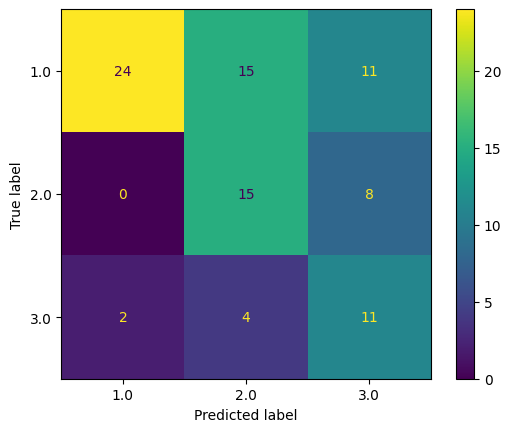

Baseline [NB]
+ acc = 0.433
+ precision = 0.586
+ recall = 0.433
+ F1-score = 0.463



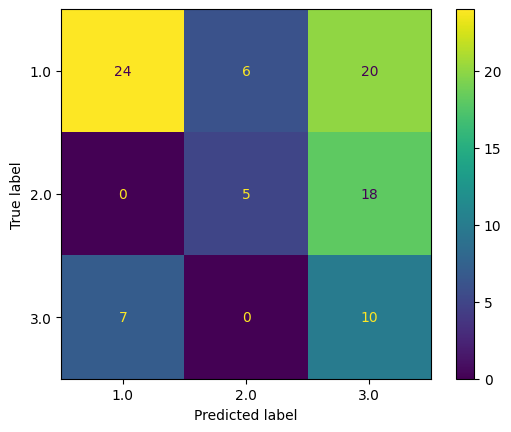

Baseline [SVM]
+ acc = 0.644
+ precision = 0.658
+ recall = 0.644
+ F1-score = 0.648



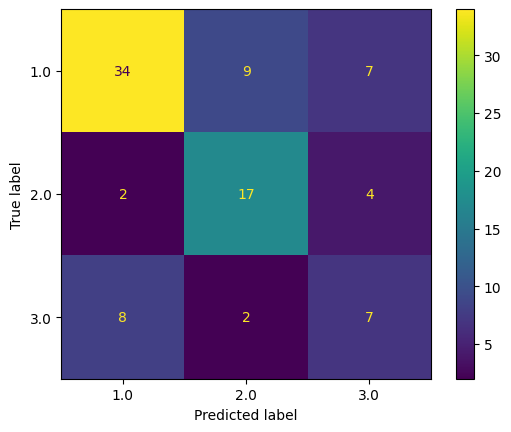

Baseline [CART]
+ acc = 0.511
+ precision = 0.564
+ recall = 0.511
+ F1-score = 0.526



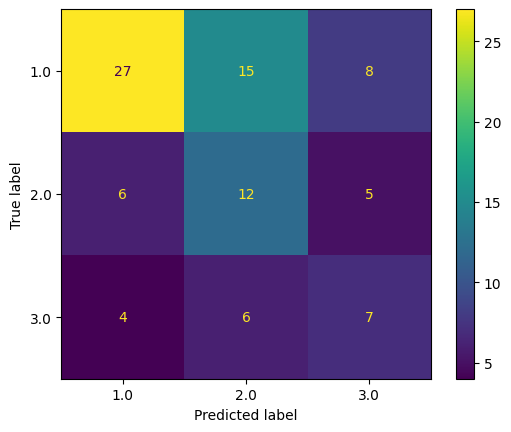

Baseline [RF]
+ acc = 0.700
+ precision = 0.699
+ recall = 0.700
+ F1-score = 0.697



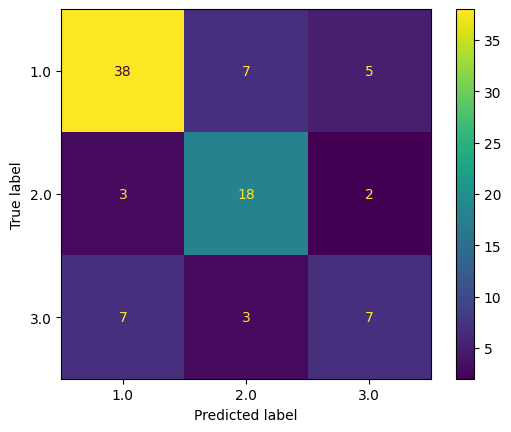

Baseline [AdaBoost]
+ acc = 0.578
+ precision = 0.614
+ recall = 0.578
+ F1-score = 0.575



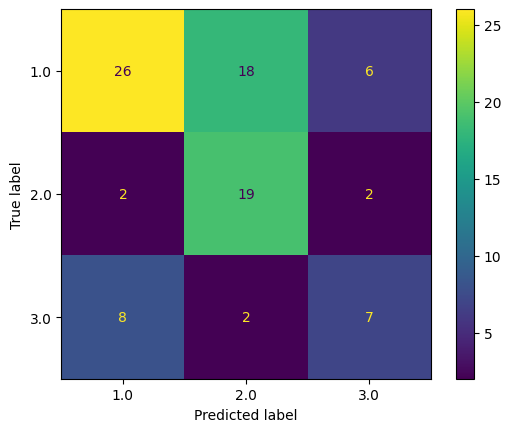

Baseline [GradientBoosting]
+ acc = 0.700
+ precision = 0.709
+ recall = 0.700
+ F1-score = 0.704



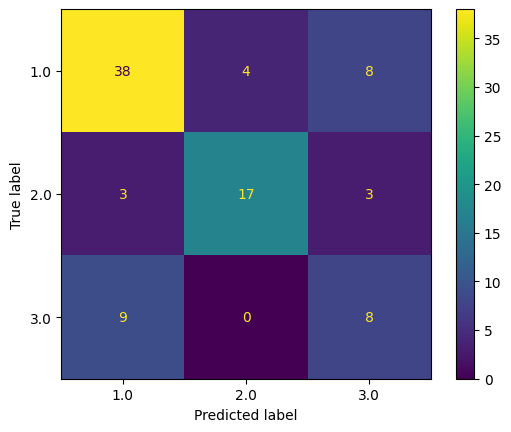

Baseline [LDA]
+ acc = 0.633
+ precision = 0.704
+ recall = 0.633
+ F1-score = 0.649



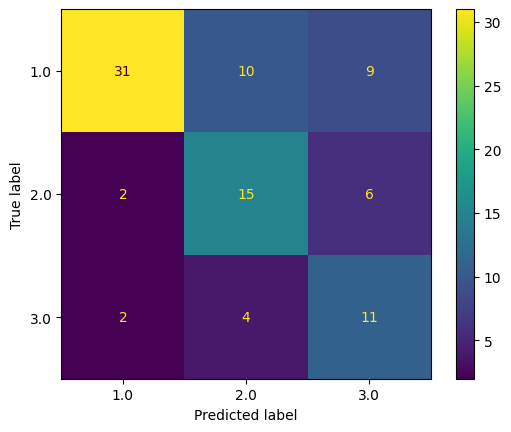

Baseline [MLP]
+ acc = 0.644
+ precision = 0.679
+ recall = 0.644
+ F1-score = 0.657



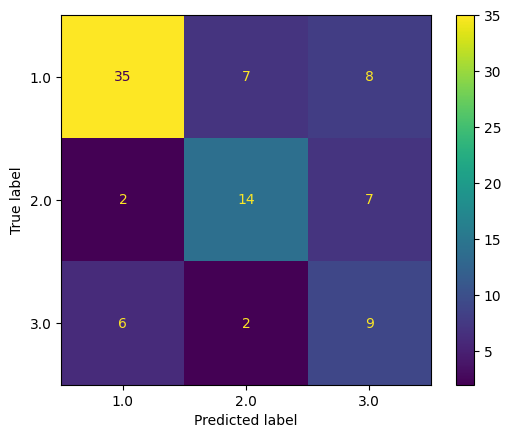

Baseline [LR]
+ acc = 0.633
+ precision = 0.673
+ recall = 0.633
+ F1-score = 0.645



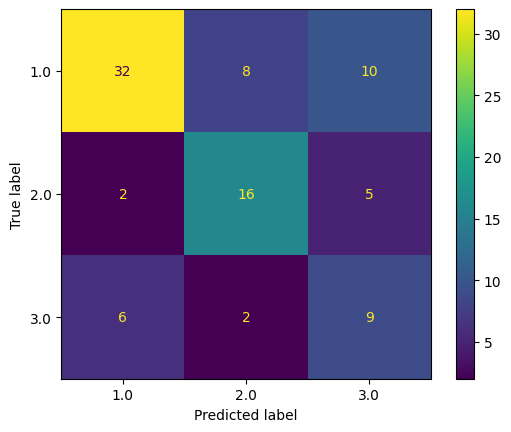

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_models = {}
test_scores = {}

for model_name, model_clf in baseline_models.items():
    y_pred_test = model_clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test, average='weighted')
    test_recall = recall_score(y_test, y_pred_test, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    # store scores
    test_scores[model_name] = {
        'Accuracy': test_acc,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1-score': test_f1
    }

    # information
    print(f'Baseline [{model_name}]')
    print(f'+ acc = {test_acc:.3f}')
    print(f'+ precision = {test_precision:.3f}')
    print(f'+ recall = {test_recall:.3f}')
    print(f'+ F1-score = {test_f1:.3f}')
    print()

    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_encoder.classes_)
    disp.plot()

    plt.show()


Tunning [RandomForest]
+ acc = 0.733


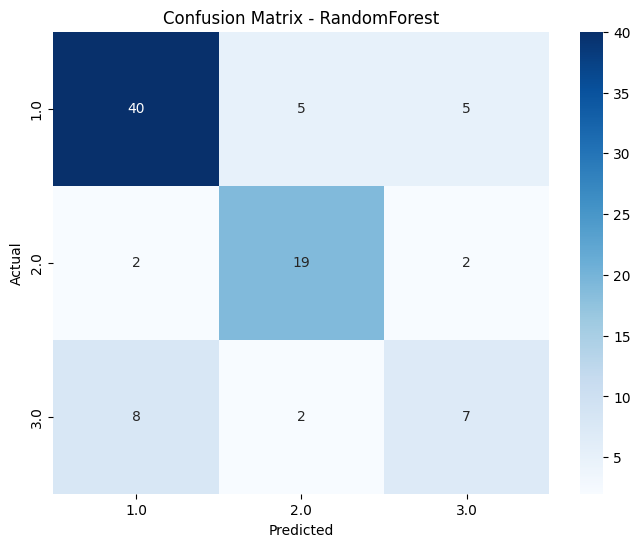

Tunning [GradientBoosting]
+ acc = 0.700


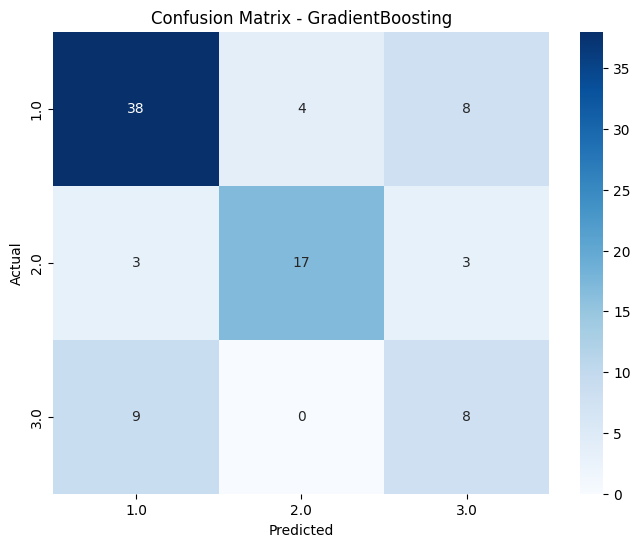

In [ ]:
import seaborn as sns

# Kiểm tra kết quả trên tập test (baseline)
for model_name in tunning_models:
    model_clf = tunning_results["best_clf"][model_name]
    y_pred_test = model_clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)

    # Information
    print(f'Tunning [{model_name}]')
    print(f'+ acc = {test_acc:.3f}')

    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_encoder.classes_, yticklabels=class_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


# Kết thúc